In [95]:
import h5py
import numpy as np
import os
from pathlib import Path
main_dir = str(Path().resolve())
from scipy.linalg import svd

In [96]:
gaze_data = []
for data_file in os.listdir(os.path.join(main_dir,'gaze_capture','bottle_gaze_data')):
    data = h5py.File(os.path.join(main_dir,'gaze_capture','bottle_gaze_data',data_file),'r')
    data_dict = {int(k):v.value for k,v in data.items()}
    gaze_data.append(data_dict)

C:\Users\Wei\.conda\envs\sparse\lib\site-packages\ipykernel_launcher.py:4: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  after removing the cwd from sys.path.


In [97]:
data_np = {k[0]: np.concatenate(v) for k,v in [list(zip(*l)) for l in zip(*[list(d.items()) for d in gaze_data])]}

In [98]:
stacked_data = np.concatenate(list(data_np.values()))
stacked_data_mean = np.mean(stacked_data,axis=0).T
stacked_data -= stacked_data_mean

In [99]:
u,s,wh = svd(stacked_data, full_matrices=False)
print(s[:10])

[19.921753  15.094148   9.389246   7.639483   7.0602026  5.4112616
  5.2621994  4.4799743  3.728068   3.5562825]


In [100]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [101]:
w = wh[1:4].T
scores = {k: (v-stacked_data_mean)@w for k,v in data_np.items()}

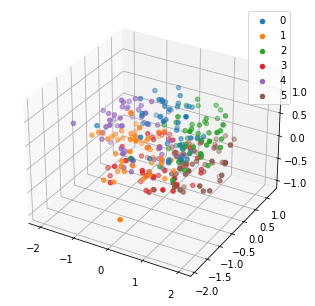

In [102]:
fig = plt.figure()
ax = Axes3D(fig)
for k,v in scores.items():
    ax.scatter(*(v.T),label=k)
    plt.legend()

In [103]:
w = wh[1:3].T
scores = {k: (v-stacked_data_mean)@w for k,v in data_np.items()}

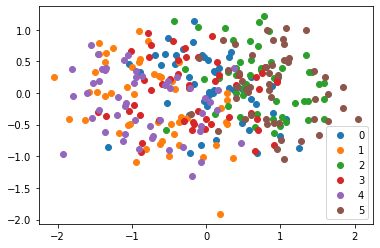

In [104]:
for k,v in scores.items():
    plt.scatter(*(v.T),label=k)
    plt.legend()

In [105]:
import torch as th
from torch import nn
from torch.nn import functional as F
from torch import optim

In [108]:
data_y = np.zeros(300)
for i in range(6):
    data_y[i*50:(i+1)*50] = i
    
def get_batch(batch_size):
    indices = np.random.choice(range(300),size=(batch_size,),replace=False)
    batch = dict(observations=stacked_data[indices],target_index=data_y[indices])
    return batch

In [115]:
from collections import OrderedDict

model = nn.Sequential(*[
    nn.Linear(128,256),
    nn.ReLU(),
    nn.LayerNorm(256),
    nn.Linear(256,256),
    nn.ReLU(),
    nn.LayerNorm(256),
    nn.Linear(256,6)
])

In [116]:
optimizer = optim.Adam(model.parameters(),lr=1e-3)

from tqdm import tqdm
epochs = int(1e4)
t = tqdm(range(epochs))
for epoch in t:
    batch = get_batch(128)
    for key,value in batch.items():
        batch[key] = th.tensor(value).float()
    obs = batch['observations']
    target = batch['target_index']
    pred = model(obs)
    loss = F.cross_entropy(pred,target.flatten().long())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    acc = th.eq(pred.argmax(dim=-1).long(),target.long()).float().mean().detach().numpy()
    acc = np.around(acc,3)
    if epoch % 100 == 0:
        t.set_description("accuracy:" + str(acc))


accuracy:1.0:  16%|█▌        | 1556/10000 [00:24<01:33, 90.01it/s]


accuracy:1.0:  33%|███▎      | 3259/10000 [00:49<02:57, 38.02it/s]


accuracy:1.0:  50%|████▉     | 4992/10000 [01:14<00:59, 84.79it/s]


accuracy:1.0:  64%|██████▍   | 6379/10000 [01:37<00:55, 65.61it/s]


KeyboardInterrupt: 

In [118]:
np.save(os.path.join(main_dir,'gaze_capture','bottle_gaze_data','bottle_gaze_data_1'),data_np,allow_pickle=True)